In [20]:
import os
import sys
import warnings

Path = '/remote/tychodata/ftairli/work/Projects/ProfileReconstruction/Code/'
if Path not in sys.path: sys.path.append(Path)
warnings.filterwarnings('ignore')
    
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from Dataset2 import ProcessingDatasetContainer



In [21]:
# Load Model and Tracker Here
Name = 'Model_Geom_Conv_0'
Model = torch.load(f'{Name}.pt')
Tracker = torch.load(f'{Name}_Tracker.pt')
print(Model.Description)


    Simple Conv2D Model for SDP Reconstruction
    3x 5x5 and 3x 3x3 Conv2d Layers followed by 3x 3x3 Conv2d Layers into 6x Fully Connected Layers
    


In [22]:
# Import Dataset Here

datapath = '/remote/tychodata/ftairli/work/Projects/ProfileReconstruction/Data/'
Dataset = ProcessingDatasetContainer(datapath)
print(Dataset.Name)
print(Dataset.Truth_Keys)
# Dataset = torch.load('/remote/tychodata/ftairli/work/Projects/ProfileReconstruction/Data/SDP_CONV_Dataset.pt')
# Dataset.AssignIndices()

# def Unnormalise_Geom(Truth): # Just for Truth Func below
#     Truth[:,0] = torch.acos(Truth[:,0])
#     Truth[:,1] *=30000
#     Truth[:,2] *=22000
#     return Truth


# Dataset.Unnormalise_Truth = Unnormalise_Geom

Unassigned_Run010
('Chi0', 'Rp', 'T0')


In [23]:
# Some Information
print(f'Final Epoch          : {len(Tracker.EpochLoss["Total"])}')
print(f'Final Loss           : {Tracker.EpochLoss["Total"][-1]}')
print(f'Final Validation Loss: {Tracker.EpochValLoss["Total"][-1]}')

Final Epoch          : 28
Final Loss           : 0.039030968086115024
Final Validation Loss: 0.05945510417222977


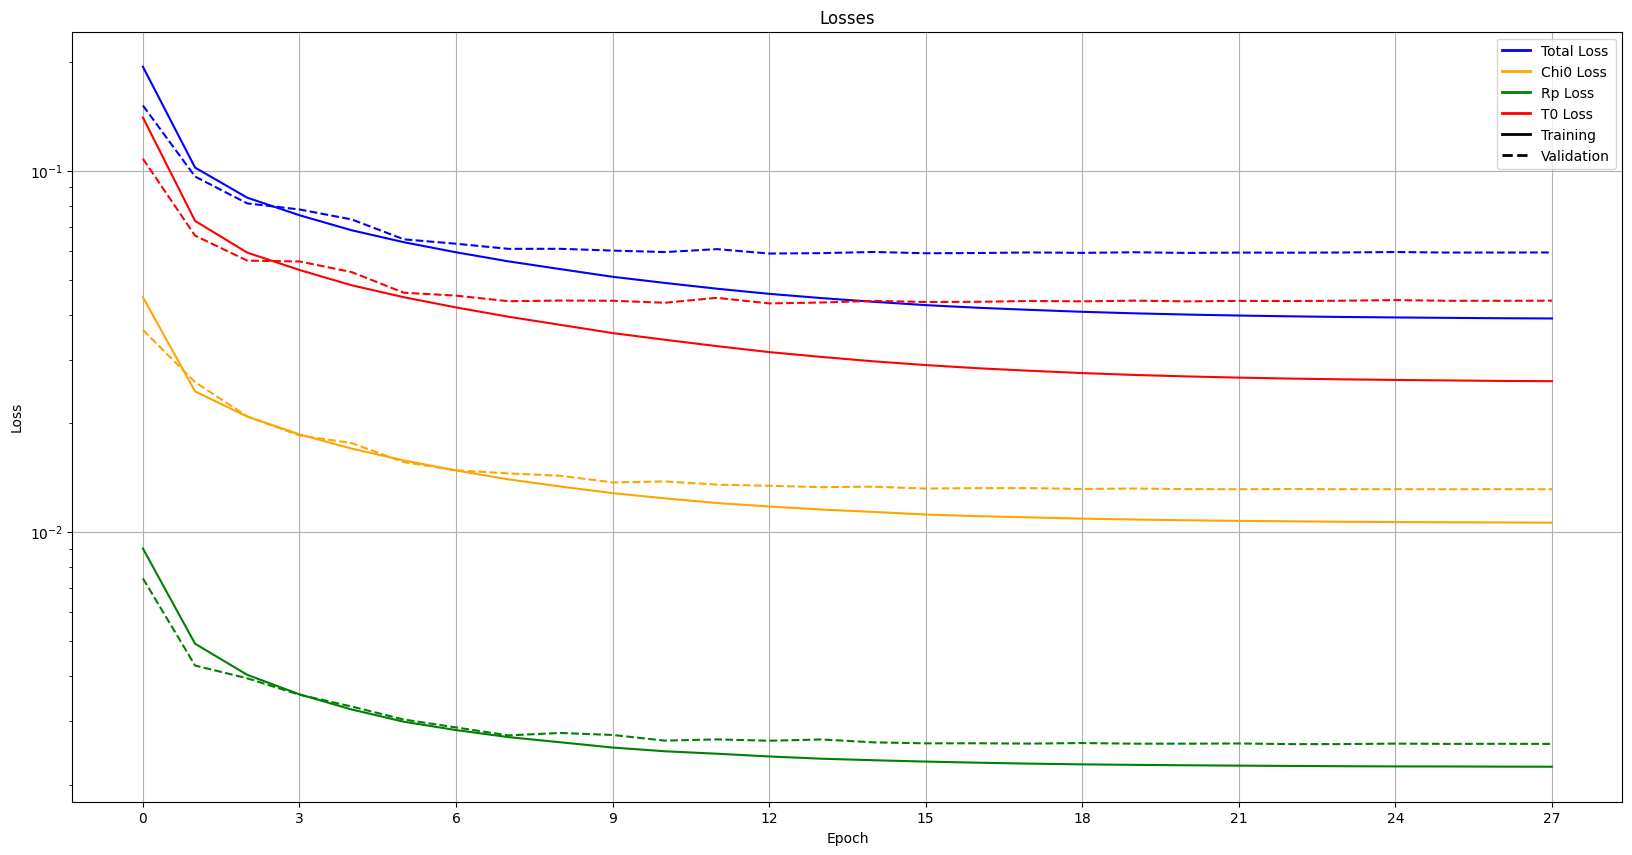

In [24]:
# Loss Plot
EpochLosses    = Tracker.EpochLoss
EpochValLosses = Tracker.EpochValLoss
Keys = list(EpochLosses.keys())
Nepochs = len(EpochLosses[Keys[0]])

ax = plt.figure(figsize=(20, 10)).gca()

# Define colors
colors = ['blue', 'orange', 'green', 'red','cyan']


custom_lines = []
custom_keys  = []
for i in range(len(Keys)):
    plt.plot(EpochLosses[Keys[i]]   , color=colors[i], label=Keys[i] + ' - Training')
    plt.plot(EpochValLosses[Keys[i]], color=colors[i], label=Keys[i] + ' - Validation', linestyle='dashed')
    custom_lines.append(Line2D([0], [0], color=colors[i], lw=2))
    custom_keys.append(Keys[i]+' Loss')

custom_lines+= [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='black', lw=2, linestyle='dashed')]
custom_keys += ['Training', 'Validation']


ax.legend(custom_lines, custom_keys)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) # integer ticks
ax.set_title('Losses')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.grid()

In [25]:
# Define some metrics
def MeanSquaredError(Truths,Predictions):
    return ((Truths-Predictions)**2).mean()
def MeanAbsoluteError(Truths,Predictions):
    return (np.abs(Truths-Predictions)).mean() if type(Truths) != torch.Tensor else (torch.abs(Truths-Predictions)).mean()
def Percentile68(Truths,Predictions):
    return np.percentile(np.abs(Truths-Predictions),68) if type(Truths) != torch.Tensor else torch.quantile(torch.abs(Truths-Predictions),0.68)

In [26]:
# Compute the Test Set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



Dataset.State      = 'Test'
Dataset.BatchSize  = len(Dataset)//256
Dataset.RandomIter = False
Truth = []
Pred  = []
Rec   = []
Model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec in Dataset:
        # Send to device
        BatchMains = [Main.to(device) for Main in BatchMains]
        BatchAux   = BatchAux.to(device)
        

        Truth .append(BatchTruth)
        Pred  .append(Model(BatchMains, BatchAux).cpu())
        Rec   .append(BatchRec)
        EvI+=1

Truth = torch.cat(Truth, dim=0)
Pred  = torch.cat(Pred , dim=0)
Rec   = torch.cat(Rec  , dim=0)

print(f'Pred Loss {MeanSquaredError(Truth,Pred)}')
print(f'Rec  Loss {MeanSquaredError(Truth,Rec )}')

Truth = Dataset.Unnormalise_Truth(Truth)
Pred  = Dataset.Unnormalise_Truth(Pred)
Rec   = Dataset.Unnormalise_Truth(Rec)

# drop NaN values
if True:
    Mask = ~torch.isnan(Truth[:,0]) & ~torch.isnan(Truth[:,1]) & ~torch.isnan(Pred[:,0]) & ~torch.isnan(Pred[:,1]) & ~torch.isnan(Rec[:,0]) & ~torch.isnan(Rec[:,1])
    print(f'Dropping {len(Truth) - Mask.sum()} NaN values')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]
    NanLocs = torch.where(Mask==0)
    print(f' Nan Locations {NanLocs}')

# Remove Bad events
if False:
    Mask = (torch.abs(Truth[:,0]-Rec[:,0]) < 1) & (torch.abs(Truth[:,1]-Rec[:,1]) < 1000)
    print(f'Dropping {len(Truth) - Mask.sum()} Bad events')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]


Truth = Truth.numpy()
Pred  = Pred .numpy()
Rec   = Rec  .numpy()


print(Truth.shape)
print(Pred.shape)



Pred Loss 0.01883923076093197
Rec  Loss 0.0022034430876374245
Dropping 0 NaN values
 Nan Locations (tensor([], dtype=torch.int64),)
(18559, 3)
(18559, 3)


In [27]:
# Compute Metric
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

Pred68 = []
Rec68  = []

for i in range(len(TruthKeys)):
    if TruthUnits[i] == 'rad': 
        AngDivPred = np.arctan2(np.sin(Truth[:,i]-Pred[:,i]),np.cos(Truth[:,i]-Pred[:,i]))
        AngDivRec  = np.arctan2(np.sin(Truth[:,i]-Rec[:,i] ),np.cos(Truth[:,i]-Rec[:,i] ))
        Pred68.append(np.percentile(np.abs(AngDivPred),68))
        Rec68 .append(np.percentile(np.abs(AngDivRec ),68))
    elif TruthUnits[i] == 'deg':
        AngDivPred = np.arctan2(np.sin(np.deg2rad(Truth[:,i]-Pred[:,i])),np.cos(np.deg2rad(Truth[:,i]-Pred[:,i])))
        AngDivRec  = np.arctan2(np.sin(np.deg2rad(Truth[:,i]-Rec[:,i] )),np.cos(np.deg2rad(Truth[:,i]-Rec[:,i] )))
        Pred68.append(np.rad2deg(np.percentile(np.abs(AngDivPred),68)))
        Rec68 .append(np.rad2deg(np.percentile(np.abs(AngDivRec ),68)))
    else:
        Pred68.append(np.percentile(np.abs(Truth[:,i]-Pred[:,i]),68))
        Rec68 .append(np.percentile(np.abs(Truth[:,i]-Rec [:,i]),68))

# Print Out the values
    
for i in range(len(TruthKeys)):
    if TruthUnits[i] == 'rad': # Convert to degrees
        print(f'Adjusted Percentile for Pred {(TruthKeys[i]+"                          ")[:10]} {Pred68[i]*180/np.pi:.5} deg')
        print(f'Adjusted Percentile for Rec  {(TruthKeys[i]+"                          ")[:10]} {Rec68[i] *180/np.pi:.5} deg')
        print(f'Percentile Ratio   Pred/Rec             {Pred68[i]/Rec68[i]:.5}')
        print()
    else:
        print(f'Adjusted Percentile for Pred {(TruthKeys[i]+"                          ")[:10]} {Pred68[i]:.5} {TruthUnits[i]}')
        print(f'Adjusted Percentile for Rec  {(TruthKeys[i]+"                          ")[:10]} {Rec68[i] :.5} {TruthUnits[i]}')
        print(f'Percentile Ratio   Pred/Rec             {Pred68[i]/Rec68[i]:.5}')
        print()


Adjusted Percentile for Pred Chi0       5.7361 deg
Adjusted Percentile for Rec  Chi0       0.40263 deg
Percentile Ratio   Pred/Rec             14.247

Adjusted Percentile for Pred Rp         1228.4 m
Adjusted Percentile for Rec  Rp         37.904 m
Percentile Ratio   Pred/Rec             32.408

Adjusted Percentile for Pred T0         2735.9 100 ns
Adjusted Percentile for Rec  T0         248.05 100 ns
Percentile Ratio   Pred/Rec             11.03



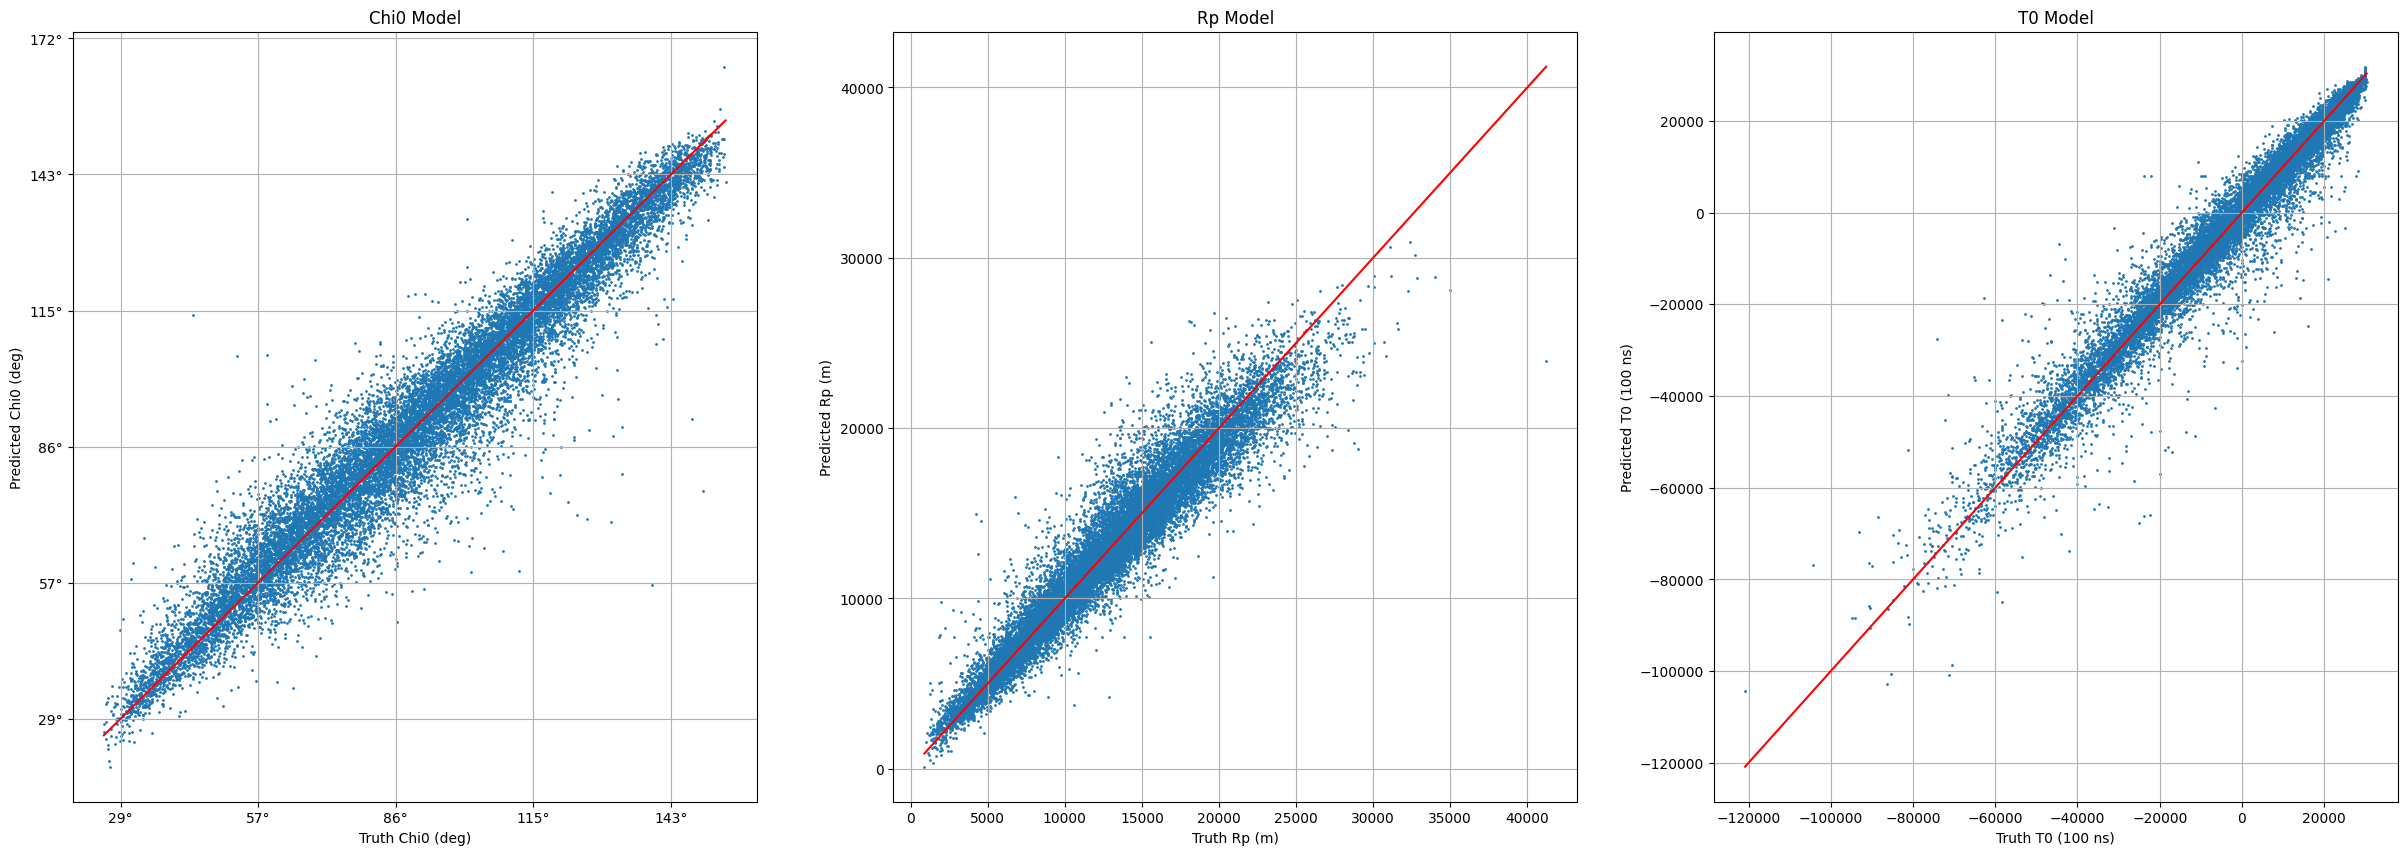

In [28]:
# Easy Scatter Plots of Predicted vs Truth
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

fig, ax = plt.subplots(1, len(TruthKeys), figsize=(10*len(TruthKeys), 10))

for i in range(len(TruthKeys)):
    ax[i].scatter(Truth[:, i], Pred[:, i], s=1)
    ax[i].plot([min(Truth[:, i]), max(Truth[:, i])], [min(Truth[:, i]), max(Truth[:, i])], 'r')
    if TruthUnits[i] == 'rad': # Change to degrees
        xticks = ax[i].get_xticks()
        ax[i].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
        yticks = ax[i].get_yticks()
        ax[i].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} (deg)')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} (deg)')
    else:
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} ({TruthUnits[i]})')
    ax[i].set_title(f'{TruthKeys[i]} Model')
    ax[i].grid()

plt.show()


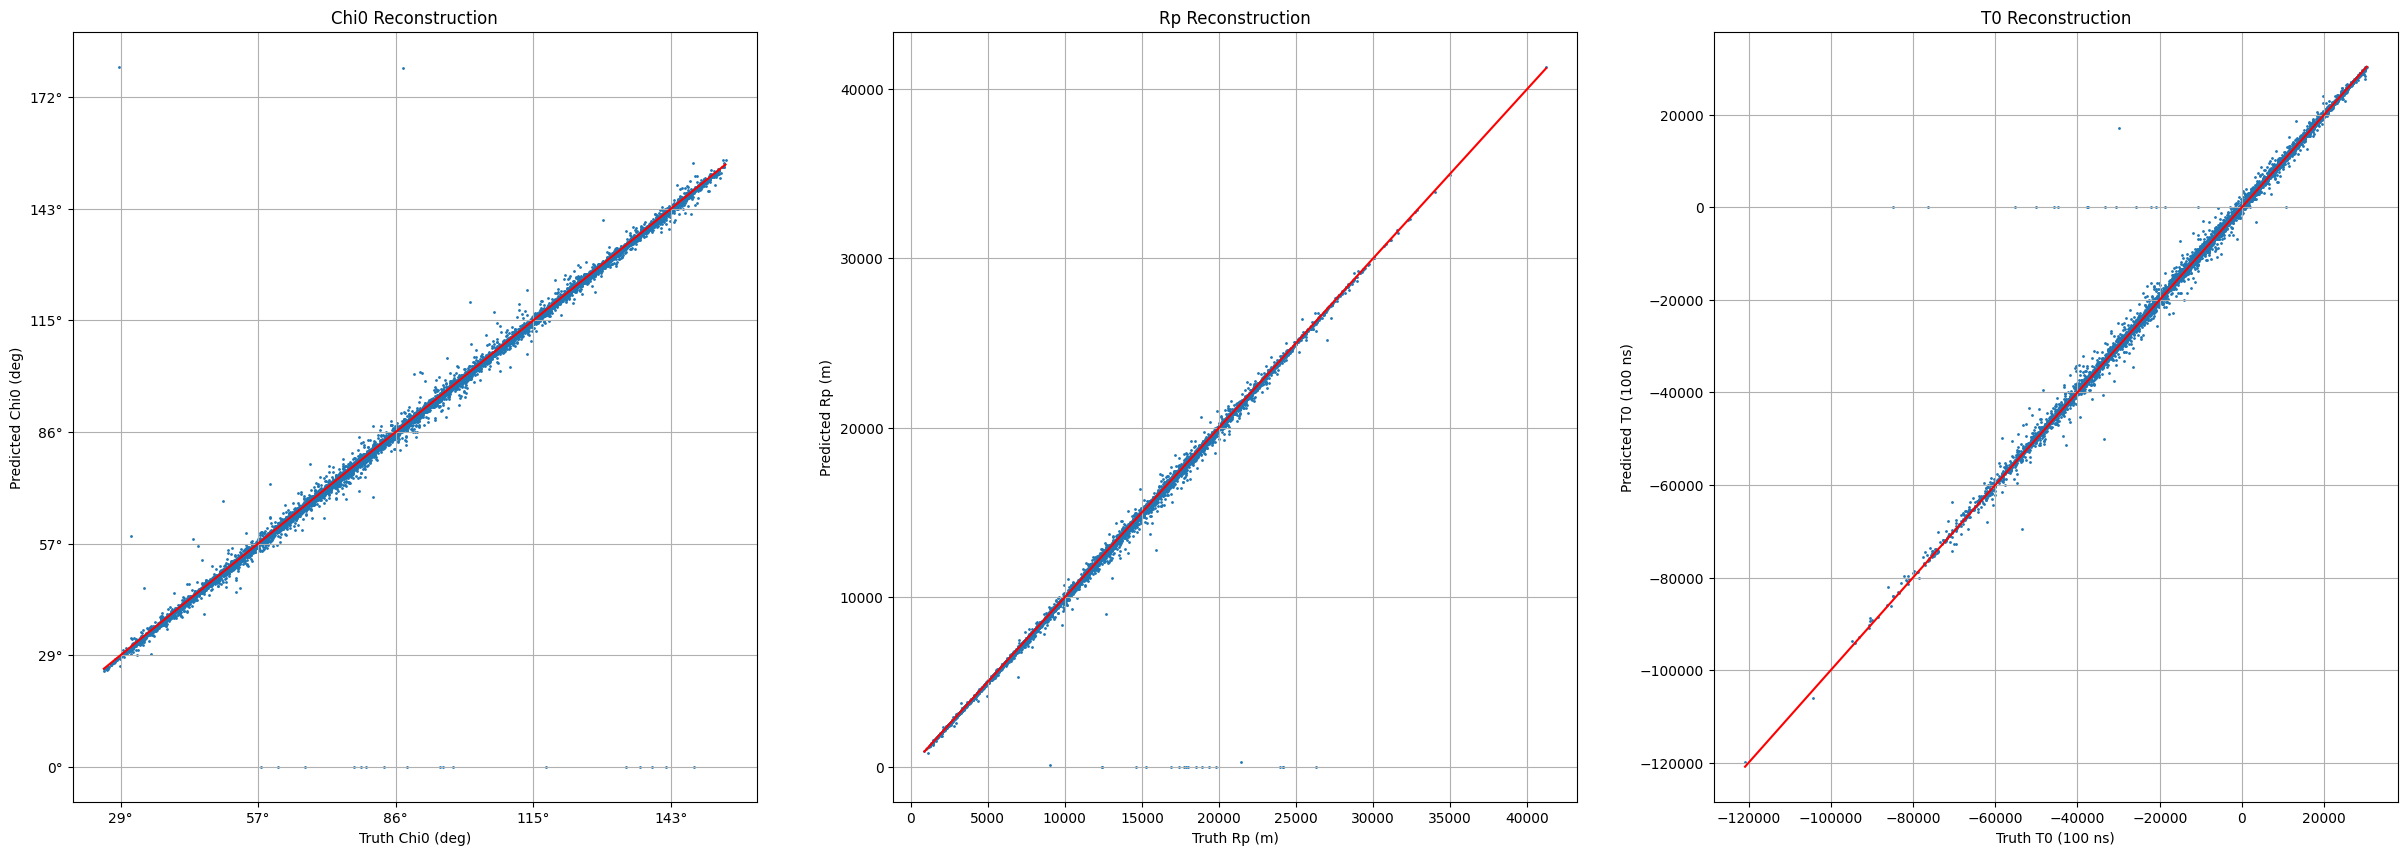

In [29]:
# Easy Scatter Plots of Reconstructed vs Truth
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

fig, ax = plt.subplots(1, len(TruthKeys), figsize=(10*len(TruthKeys), 10))

for i in range(len(TruthKeys)):
    ax[i].scatter(Truth[:, i], Rec[:, i], s=1)
    ax[i].plot([min(Truth[:, i]), max(Truth[:, i])], [min(Truth[:, i]), max(Truth[:, i])], 'r')
    if TruthUnits[i] == 'rad': # Change to degrees
        xticks = ax[i].get_xticks()
        ax[i].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
        yticks = ax[i].get_yticks()
        ax[i].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} (deg)')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} (deg)')
    else:
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} ({TruthUnits[i]})')
    ax[i].set_title(f'{TruthKeys[i]} Reconstruction')
    ax[i].grid()

plt.show()


In [30]:
def DeviationPlot(TruthKeys,TruthUnits,Truth,Pred,Type):
    fig, ax = plt.subplots(1, len(TruthKeys), figsize=(12.5*len(TruthKeys), 10))
    for i in range(len(TruthKeys)):
        X = Truth[:, i] if TruthUnits[i] != 'rad' else Truth[:, i]/np.pi*180
        Y = Pred[:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Pred[:, i] - Truth[:, i])/np.pi*180
        
        
        # Scaling Cuts
        if TruthKeys[i] == 'SDPTheta':
            cut = (X > 0.1) & (np.abs(Y)<6)
        elif TruthKeys[i] == 'SDPPhi':
            cut = (np.abs(Y)<3) & (np.abs(X)<50)
        elif TruthKeys[i] == 'Chi0':
            cut = (np.abs(Y)<20)
        elif TruthKeys[i] == 'Rp':
            cut = (np.abs(Y)<5000)
        elif TruthKeys[i] == 'T0':
            cut = (np.abs(Y)<10000)
        else:
            cut = (np.abs(Y)>0)


        X = X[cut]
        Y = Y[cut]

        sns.scatterplot(x=X, y=Y, ax=ax[i], s=5,color='black')
        sns.histplot(x=X, y=Y, ax=ax[i], bins=100, pthresh=0.1,cmap = 'inferno',cbar = True)
        if TruthUnits[i] != 'rad': 
            ax[i].set_ylabel(f'{Type}-Truth ({TruthUnits[i]})')
            ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
            
        else:                      
            ax[i].set_ylabel(f'{Type}-Truth (degrees)')
            ax[i].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')
        
        ax[i].set_title(f'{TruthKeys[i]} - {Type}')
        ax[i].set_xlim(min(X),max(X))
        ax[i].grid()
        # 68th Percentile
        Percentile68 = np.percentile(np.abs(Y),68)
        # Add as a texbox to top right of plot
        if TruthUnits[i]!= 'rad': ax[i].text(0.95, 0.95, f'$\\sigma$: {Percentile68:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i].transAxes, fontsize=15)
        else: ax[i].text(0.95, 0.95, f'$\\sigma$: {Percentile68:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i].transAxes, fontsize=15)

        ax[i].axhline(Percentile68, color='cyan', linestyle='--')
        ax[i].axhline(-Percentile68, color='cyan', linestyle='--')

    plt.show()


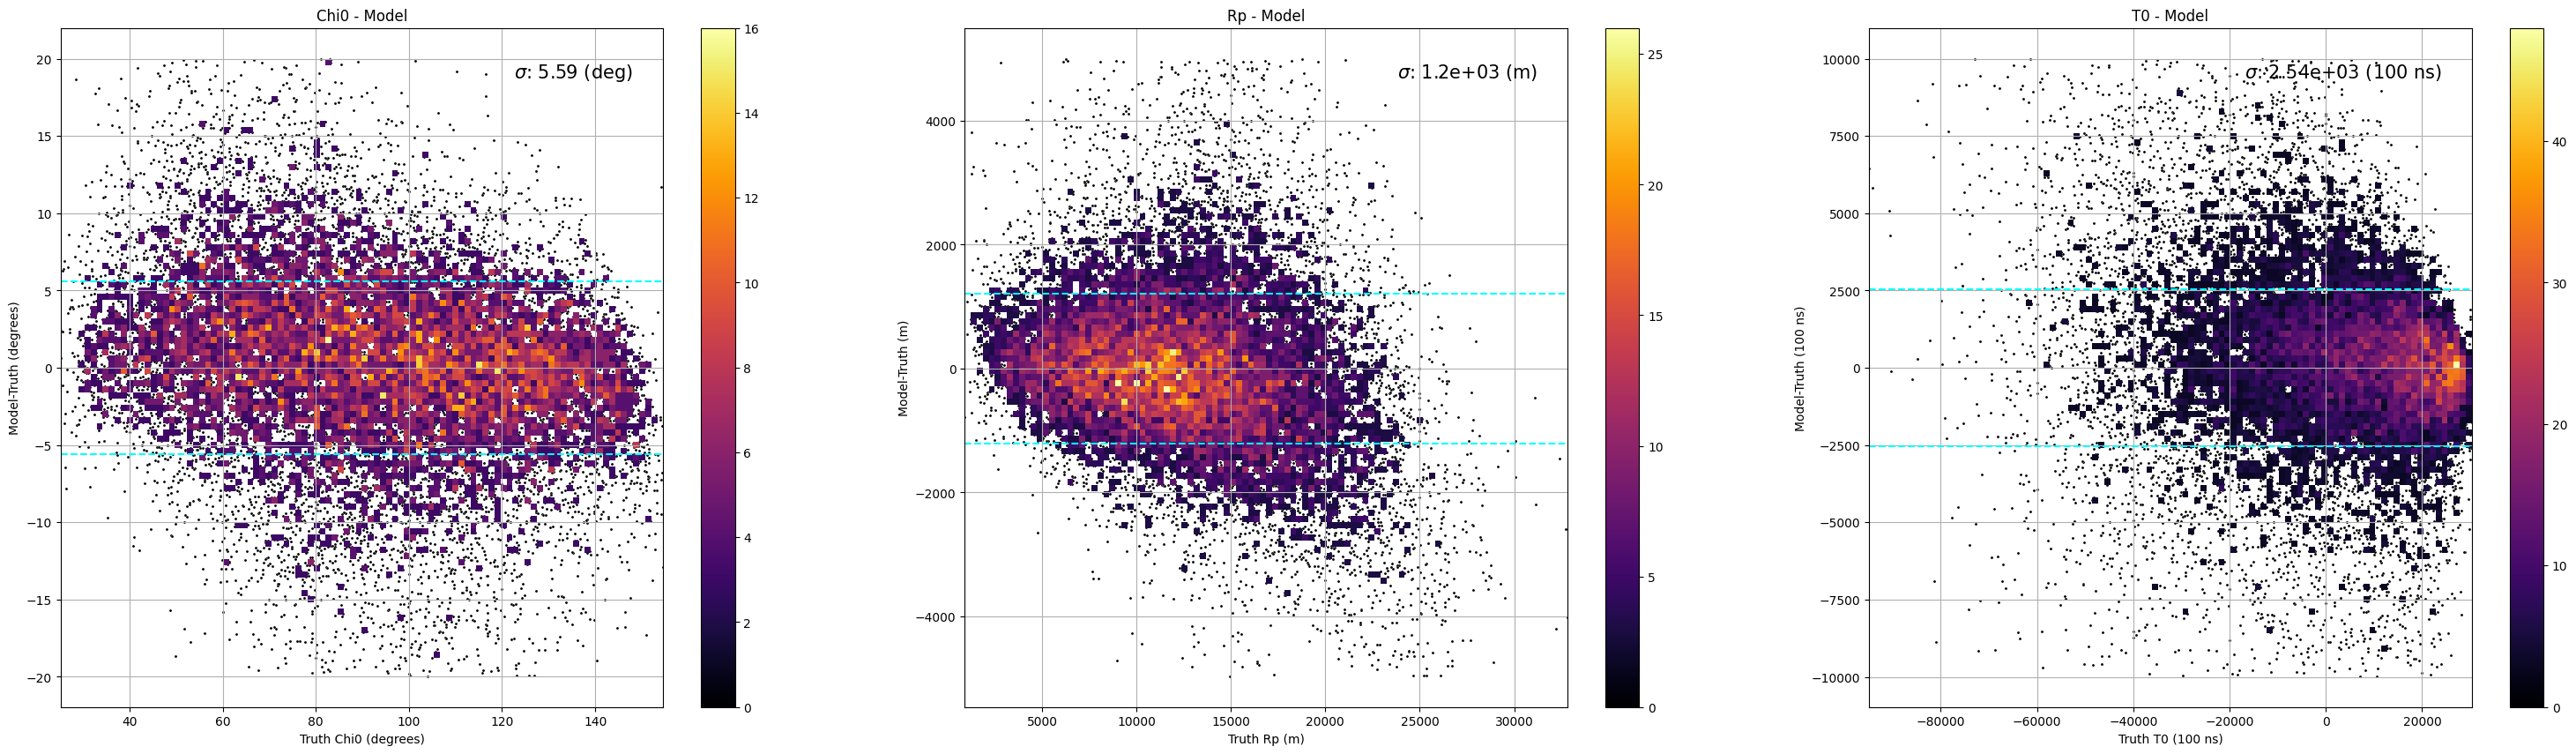

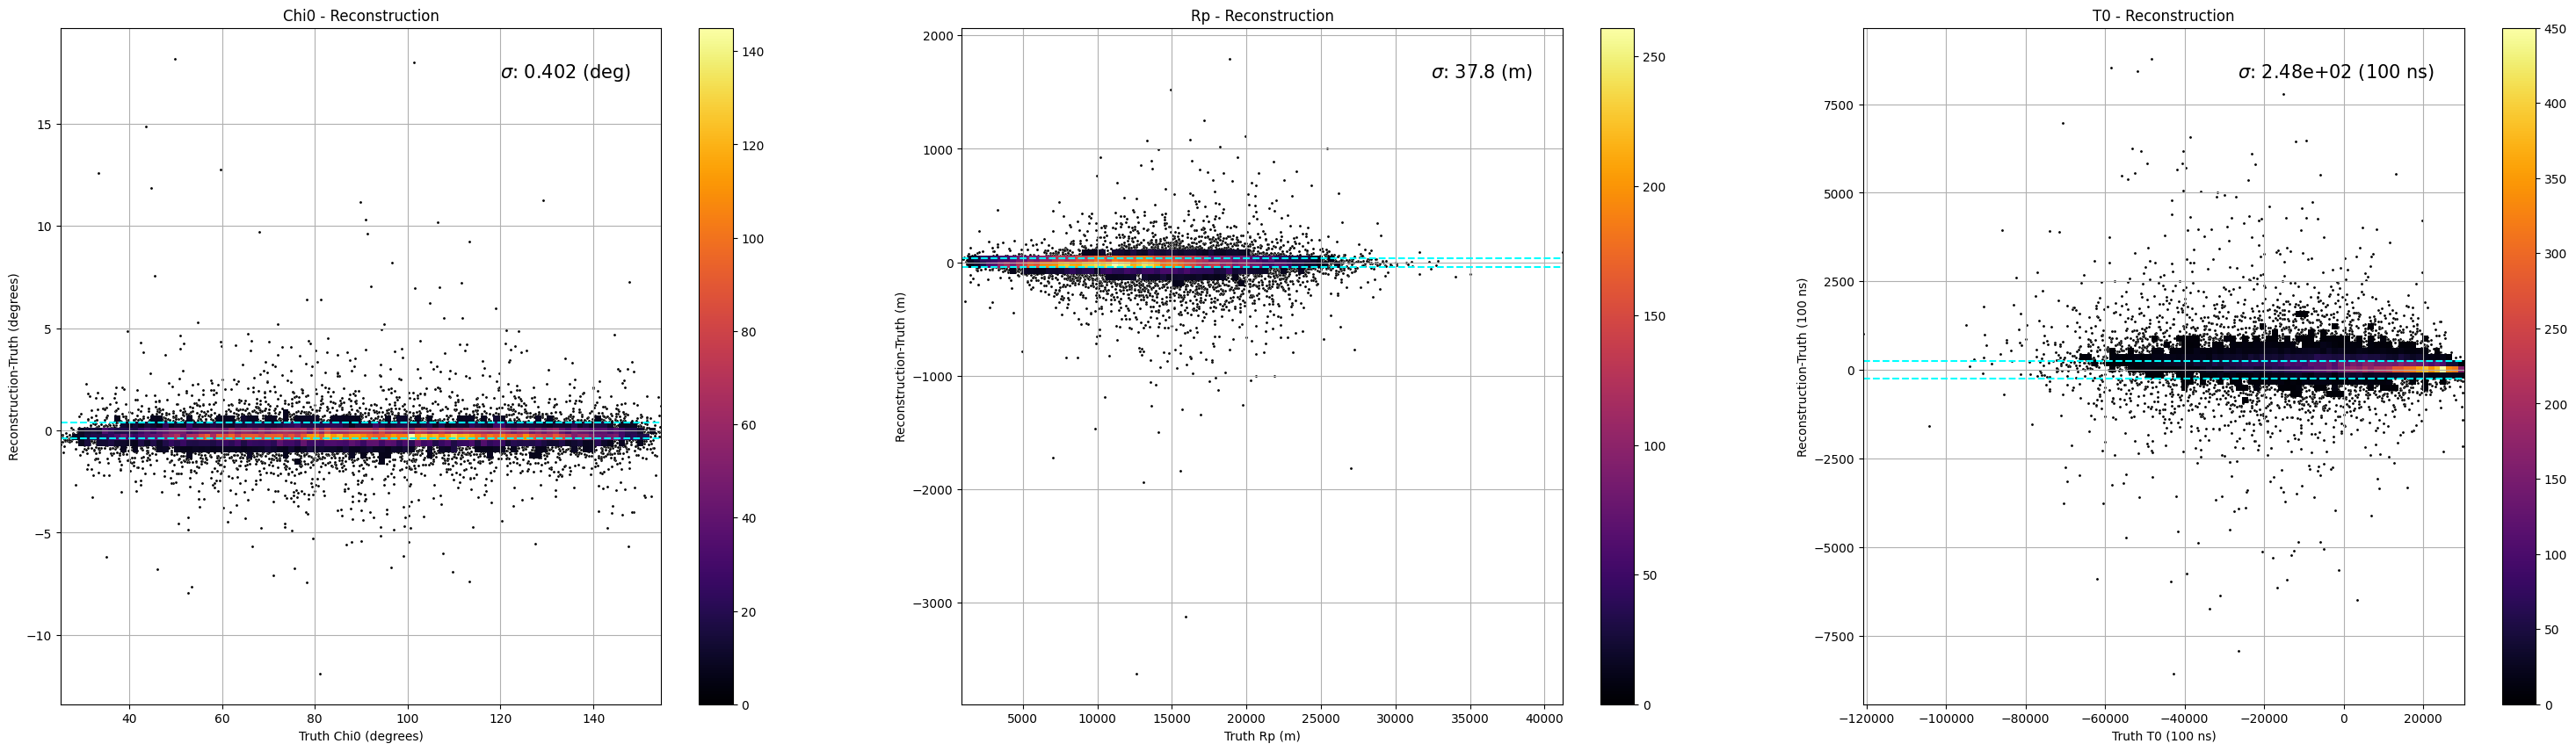

In [31]:
# Deviation Plots
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

DeviationPlot(TruthKeys,TruthUnits,Truth,Pred,'Model')
DeviationPlot(TruthKeys,TruthUnits,Truth,Rec,'Reconstruction')

In [32]:
# Compute the Test Set with EVENT SIZE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



Dataset.State      = 'Test'
Dataset.BatchSize  = len(Dataset)//256
Dataset.RandomIter = False
Truth  = []
Pred   = []
Rec    = []
EvSize = []
Model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec in Dataset:
        # Send to device
        BatchMains = [Main.to(device) for Main in BatchMains]
        BatchAux   = BatchAux.to(device)
        

        Truth .append(BatchTruth)
        Pred  .append(Model(BatchMains, BatchAux).cpu())
        Rec   .append(BatchRec)
        # Calculate event Size
        EvSize.append(torch.sum(BatchMains[0][:,0,...]!=0, dim=(1,2)).cpu())
        EvI+=1

Truth  = torch.cat(Truth, dim=0)
Pred   = torch.cat(Pred , dim=0)
Rec    = torch.cat(Rec  , dim=0)
EvSize = torch.cat(EvSize,dim=0)

print(f'Pred Loss {MeanSquaredError(Truth,Pred)}')
print(f'Rec  Loss {MeanSquaredError(Truth,Rec )}')

Truth = Dataset.Unnormalise_Truth(Truth)
Pred  = Dataset.Unnormalise_Truth(Pred)
Rec   = Dataset.Unnormalise_Truth(Rec)

# drop NaN values
if True:
    Mask = ~torch.isnan(Truth[:,0]) & ~torch.isnan(Truth[:,1]) & ~torch.isnan(Pred[:,0]) & ~torch.isnan(Pred[:,1]) & ~torch.isnan(Rec[:,0]) & ~torch.isnan(Rec[:,1])
    print(f'Dropping {len(Truth) - Mask.sum()} NaN values')
    Truth  = Truth[Mask]
    Pred   = Pred [Mask]
    Rec    = Rec  [Mask]
    EvSize = EvSize[Mask]
    NanLocs = torch.where(Mask==0)
    print(f' Nan Locations {NanLocs}')

# Remove Bad events
if False:
    Mask = (torch.abs(Truth[:,0]-Rec[:,0]) < 1) & (torch.abs(Truth[:,1]-Rec[:,1]) < 1000)
    print(f'Dropping {len(Truth) - Mask.sum()} Bad events')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]


Truth  = Truth.numpy()
Pred   = Pred .numpy()
Rec    = Rec  .numpy()
EvSize = EvSize.numpy()

print(Truth.shape)
print(Pred.shape)




Pred Loss 0.01883923076093197
Rec  Loss 0.0022034430876374245
Dropping 0 NaN values
 Nan Locations (tensor([], dtype=torch.int64),)
(18559, 3)
(18559, 3)


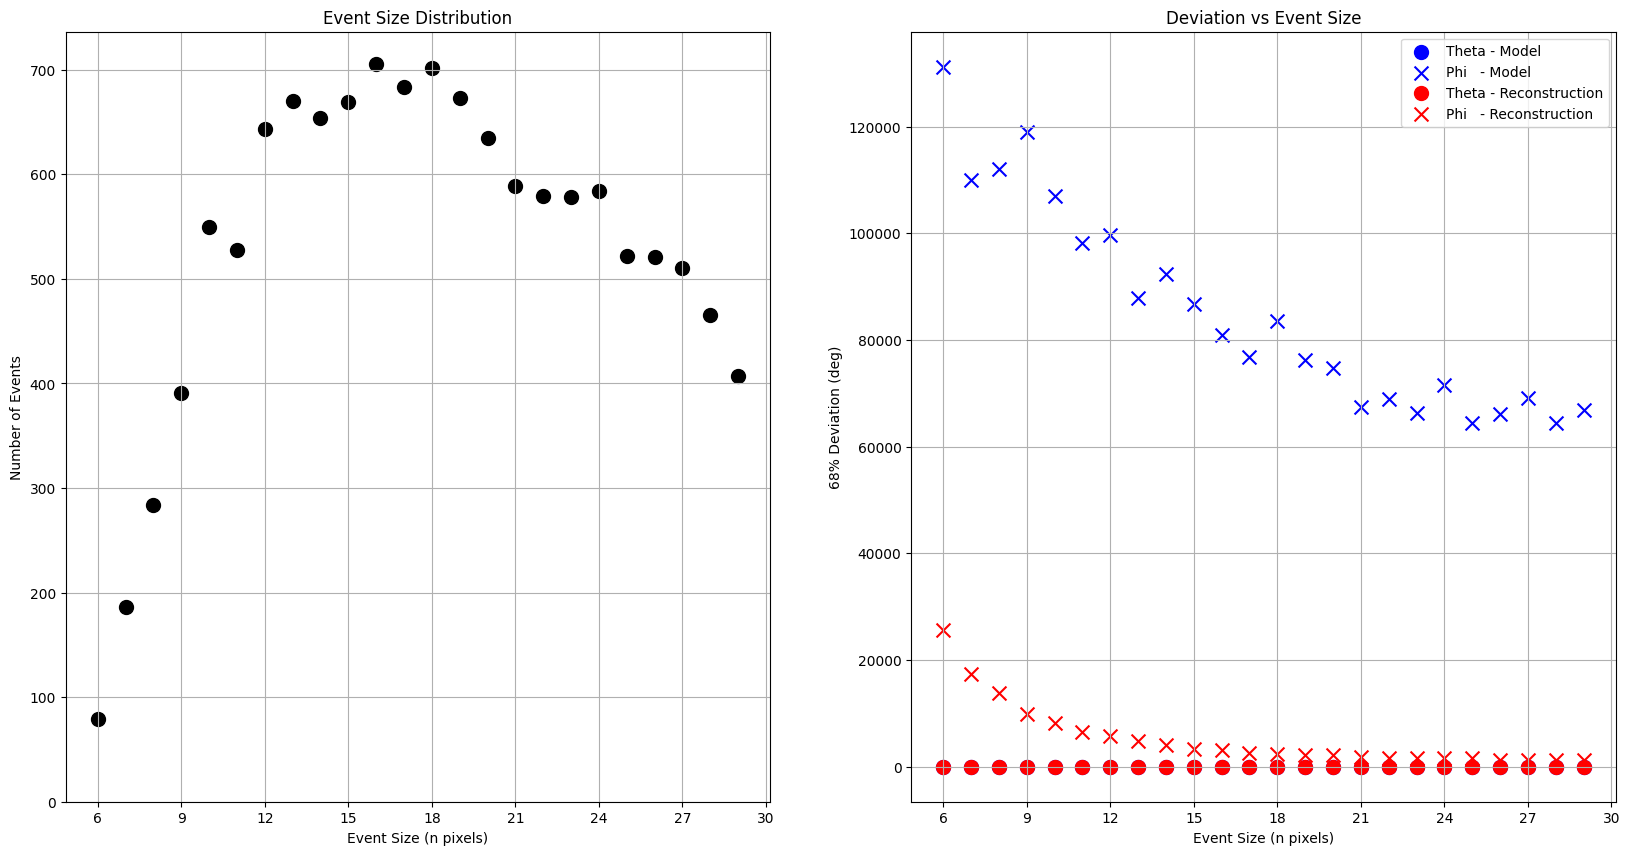

In [33]:
# Make Acuracy vs Event Size Plots SPECIFIC TO PREDICTION

from matplotlib.ticker import MaxNLocator

bot = 6
top = 30

fig,ax = plt.subplots(1,2,figsize = (20,10))
ax[0].scatter(np.arange(bot,top),np.bincount(EvSize)[bot:top],c = 'black',s=100)
ax[0].set_xlabel('Event Size (n pixels)')
ax[0].set_ylabel('Number of Events')
ax[0].set_title('Event Size Distribution')
ax[0].grid()
# Make the xticks integers
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_ylim(0)



# Calculate the Deviation 68% for every event size
Dev68Pred_Theta = []
Dev68Rec_Theta  = []
Dev68Pred_Phi   = []
Dev68Rec_Phi    = []

for i in range(bot,top):
    Cut = EvSize == i
    if np.sum(Cut)!= 0 :
        Dev68Pred_Theta.append(Percentile68(Truth[Cut,0],Pred[Cut,0]))
        Dev68Rec_Theta .append(Percentile68(Truth[Cut,0],Rec [Cut,0]))
        Dev68Pred_Phi  .append(Percentile68(Truth[Cut,1],Pred[Cut,1]))
        Dev68Rec_Phi   .append(Percentile68(Truth[Cut,1],Rec [Cut,1]))
    else:
        Dev68Pred_Theta.append(0)
        Dev68Rec_Theta .append(0)
        Dev68Pred_Phi  .append(0)
        Dev68Rec_Phi   .append(0)
# Convert to Degrees
Dev68Pred_Theta = np.array(Dev68Pred_Theta)*180/np.pi
Dev68Rec_Theta  = np.array(Dev68Rec_Theta )*180/np.pi
Dev68Pred_Phi   = np.array(Dev68Pred_Phi  )*180/np.pi
Dev68Rec_Phi    = np.array(Dev68Rec_Phi   )*180/np.pi

ax[1].scatter(np.arange(bot,top),Dev68Pred_Theta,c = 'blue',s=100,label='Theta - Model')
ax[1].scatter(np.arange(bot,top),Dev68Pred_Phi  ,c = 'blue',s=100,label='Phi   - Model',marker='x')
ax[1].scatter(np.arange(bot,top),Dev68Rec_Theta ,c = 'red' ,s=100,label='Theta - Reconstruction')
ax[1].scatter(np.arange(bot,top),Dev68Rec_Phi   ,c = 'red' ,s=100,label='Phi   - Reconstruction',marker='x')
ax[1].set_xlabel('Event Size (n pixels)')
ax[1].set_ylabel('68% Deviation (deg)')
ax[1].set_title('Deviation vs Event Size')
ax[1].grid()
ax[1].legend()
# Make the xticks integers
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))


In [34]:
# Compute the Test Set but input is boolean mask
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



Dataset.State      = 'Test'
Dataset.BatchSize  = len(Dataset)//256
Dataset.RandomIter = False
Truth = []
Pred  = []
Rec   = []
Model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec in Dataset:
        # Send to device
        BatchMains = [Main.to(device) for Main in BatchMains]
        BatchMains = [(Main != 0).float() for Main in BatchMains] # Boolify
        BatchAux   = BatchAux.to(device)
        

        Truth .append(BatchTruth)
        Pred  .append(Model(BatchMains, BatchAux).cpu())
        Rec   .append(BatchRec)
        EvI+=1

Truth = torch.cat(Truth, dim=0)
Pred  = torch.cat(Pred , dim=0)
Rec   = torch.cat(Rec  , dim=0)

print(f'Pred Loss {MeanSquaredError(Truth,Pred)}')
print(f'Rec  Loss {MeanSquaredError(Truth,Rec )}')

Truth = Dataset.Unnormalise_Truth(Truth)
Pred  = Dataset.Unnormalise_Truth(Pred)
Rec   = Dataset.Unnormalise_Truth(Rec)

# drop NaN values
if True:
    Mask = ~torch.isnan(Truth[:,0]) & ~torch.isnan(Truth[:,1]) & ~torch.isnan(Pred[:,0]) & ~torch.isnan(Pred[:,1]) & ~torch.isnan(Rec[:,0]) & ~torch.isnan(Rec[:,1])
    print(f'Dropping {len(Truth) - Mask.sum()} NaN values')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]
    NanLocs = torch.where(Mask==0)
    print(f' Nan Locations {NanLocs}')

# Remove Bad events
if False:
    Mask = (torch.abs(Truth[:,0]-Rec[:,0]) < 1) & (torch.abs(Truth[:,1]-Rec[:,1]) < 1000)
    print(f'Dropping {len(Truth) - Mask.sum()} Bad events')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]


Truth = Truth.numpy()
Pred  = Pred .numpy()
Rec   = Rec  .numpy()


print(Truth.shape)
print(Pred.shape)



Pred Loss 1.4395042657852173
Rec  Loss 0.0022034430876374245
Dropping 0 NaN values
 Nan Locations (tensor([], dtype=torch.int64),)
(18559, 3)
(18559, 3)


In [35]:
# Compute Metric with the bool input
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

Pred68 = []
Rec68  = []

for i in range(len(TruthKeys)):
    if TruthUnits[i] == 'rad': 
        AngDivPred = np.arctan2(np.sin(Truth[:,i]-Pred[:,i]),np.cos(Truth[:,i]-Pred[:,i]))
        AngDivRec  = np.arctan2(np.sin(Truth[:,i]-Rec[:,i] ),np.cos(Truth[:,i]-Rec[:,i] ))
        Pred68.append(np.percentile(np.abs(AngDivPred),68))
        Rec68 .append(np.percentile(np.abs(AngDivRec ),68))
    elif TruthUnits[i] == 'deg':
        AngDivPred = np.arctan2(np.sin(np.deg2rad(Truth[:,i]-Pred[:,i])),np.cos(np.deg2rad(Truth[:,i]-Pred[:,i])))
        AngDivRec  = np.arctan2(np.sin(np.deg2rad(Truth[:,i]-Rec[:,i] )),np.cos(np.deg2rad(Truth[:,i]-Rec[:,i] )))
        Pred68.append(np.rad2deg(np.percentile(np.abs(AngDivPred),68)))
        Rec68 .append(np.rad2deg(np.percentile(np.abs(AngDivRec ),68)))
    else:
        Pred68.append(np.percentile(np.abs(Truth[:,i]-Pred[:,i]),68))
        Rec68 .append(np.percentile(np.abs(Truth[:,i]-Rec[:,i] ),68))

# Print Out the values
    
for i in range(len(TruthKeys)):
    if TruthUnits[i] == 'rad': # Convert to degrees
        print(f'Adjusted Percentile for Pred {(TruthKeys[i]+"                          ")[:10]} {Pred68[i]*180/np.pi:.5} deg')
        print(f'Adjusted Percentile for Rec  {(TruthKeys[i]+"                          ")[:10]} {Rec68[i] *180/np.pi:.5} deg')
        print(f'Percentile Ratio   Pred/Rec             {Pred68[i]/Rec68[i]:.5}')
        print()
    else:
        print(f'Adjusted Percentile for Pred {(TruthKeys[i]+"                          ")[:10]} {Pred68[i]:.5} {TruthUnits[i]}')
        print(f'Adjusted Percentile for Rec  {(TruthKeys[i]+"                          ")[:10]} {Rec68[i] :.5} {TruthUnits[i]}')
        print(f'Percentile Ratio   Pred/Rec             {Pred68[i]/Rec68[i]:.5}')


Adjusted Percentile for Pred Chi0       64.315 deg
Adjusted Percentile for Rec  Chi0       0.40263 deg
Percentile Ratio   Pred/Rec             159.74

Adjusted Percentile for Pred Rp         1.2854e+04 m
Adjusted Percentile for Rec  Rp         37.904 m
Percentile Ratio   Pred/Rec             339.12
Adjusted Percentile for Pred T0         3.6526e+04 100 ns
Adjusted Percentile for Rec  T0         248.05 100 ns
Percentile Ratio   Pred/Rec             147.25
